In [135]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from diagnose import evaluate_forecasts, rolling_forecast_arima, ljungbox_test, durbin_watson_test, change_data, kpss_test, adf_test, zivot_andrews_test



warnings.filterwarnings("ignore")

### CONFIGHERE ###

In [136]:
data_cutoff = -32
figsize=(12, 6)
train_size = 0.75


## 1. Eksploracja Dancych




## Opis danych

Zbiór danych składa się z jednej zmiennej finansowej zawierającej kwartalne obserwacje:

### **Net Income / Loss (wartość liczbowa, dane kwartalne)**  
Zmienna ta przedstawia zysk netto lub stratę netto osiąganą przez przedsiębiorstwo w każdym kwartale. Jest to kluczowy wskaźnik rentowności, wykorzystywany do analizy:

- efektywności finansowej w czasie,
- trendów wzrostu lub spadku wyników,
- sezonowości i cykliczności działalności,
- stabilności finansowej przedsiębiorstwa,
- identyfikacji potencjalnych czynników ryzyka.

Dane mają postać **szeregu czasowego**, w którym wartości są ułożone chronologicznie i występują w równych odstępach czasowych (co kwartał). Dzięki temu zmienna nadaje się do modelowania metodami prognostycznymi, takimi jak ARIMA, SARIMA, modele wygładzania wykładniczego, modele hybrydowe oraz algorytmy uczenia maszynowego.

---


In [137]:
df = pd.read_csv(r'Amazon Net Income by Quarter.csv')


df['Category'] = df['Category'].str.strip()

period_strings = df['Category'].str.replace(r'Q([1-4])\s*(\d{4})', r'\2Q\1', regex=True)

period_idx = pd.PeriodIndex(period_strings, freq='Q')

df.index = period_idx.to_timestamp()           

df.index.name = 'Date'  
real_case_data = df.copy().tail(-data_cutoff)
real_case_data = real_case_data.drop(columns=['Category'])
df = df.head(data_cutoff)
df = df.drop(columns=['Category'])

In [138]:
df.describe()


,Net Income/Loss
count,83.000000
mean,73.662651
std,232.279493
min,-545.000000
25%,-29.000000
50%,73.000000
75%,194.000000
max,857.000000


In [139]:

fig = px.bar(df.reset_index(),
             x='Date',
             y='Net Income/Loss',
             title='Amazon Net Income by Quarter',
             labels={'Net Income/Loss':'Net Income (in Billions)','Date':'Quarter'})

fig.update_traces(marker_color='steelblue', showlegend=False)
fig.update_layout(xaxis_tickformat='%Y-%m', xaxis_tickangle=-45)
fig.show()


## Analiza Dystrybucji

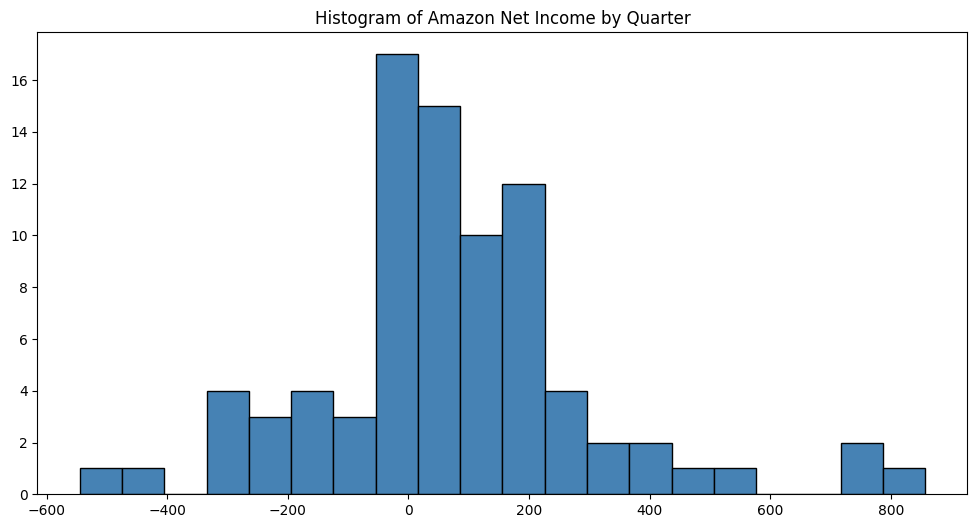

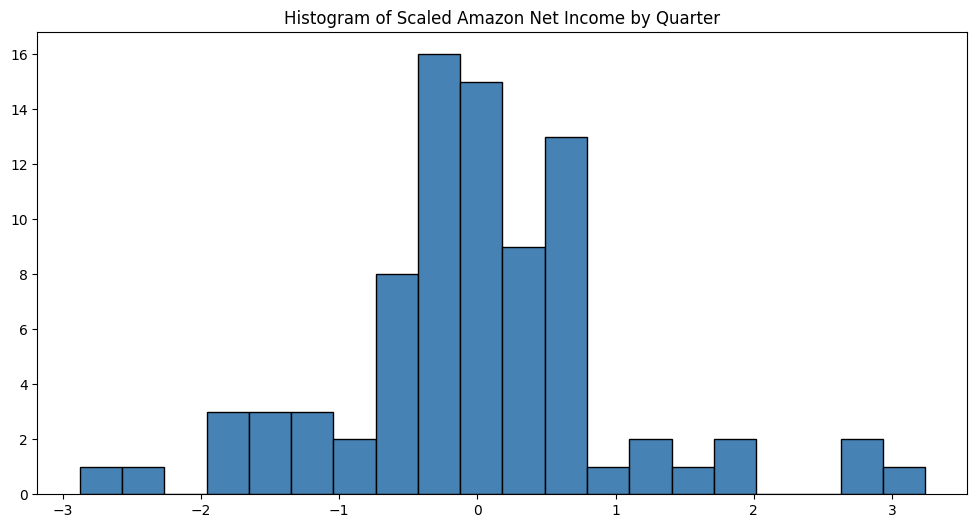

In [140]:
plt.figure(figsize=figsize)
plt.hist(df['Net Income/Loss'], bins=20, color='steelblue', edgecolor='black')
plt.title('Histogram of Amazon Net Income by Quarter')
plt.show()

pt = PowerTransformer(method='yeo-johnson')
scaled_data = pt.fit_transform(df)
plt.figure(figsize=figsize)
plt.hist(scaled_data, bins=20, color='steelblue', edgecolor='black')
plt.title('Histogram of Scaled Amazon Net Income by Quarter')
plt.show()
scaled_data = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)


## 2. Tesotwanie stacjonarności 


**Szereg czasowy stacjonarny** to taki szereg, którego własności statystyczne pozostają stałe w czasie.  
Oznacza to, że:

- **wartość oczekiwana (średnia)** jest stała,
- **wariancja** jest stała (nie zależy od czasu),
- **kowariancja/autokowariancja** zależy wyłącznie od opóźnienia (lag), a nie od konkretnego momentu czasu.

W praktyce szereg stacjonarny nie wykazuje trendu ani systematycznych zmian zmienności, a jego struktura statystyczna nie zmienia się wraz z upływem czasu.


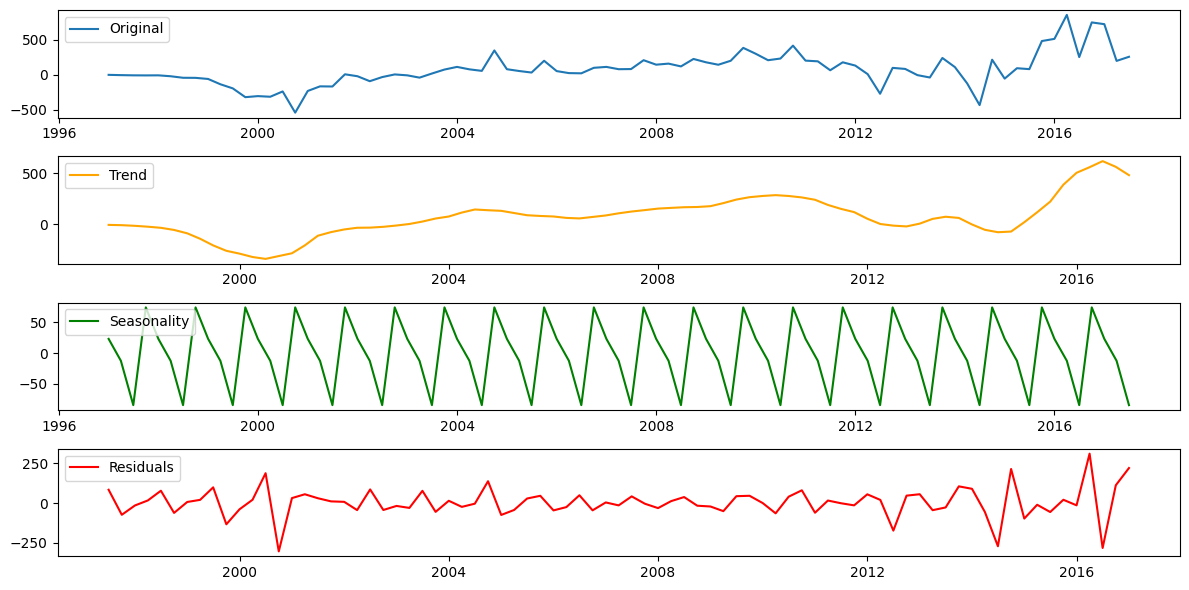

In [141]:
from diagnose import seasonal_decompose_plot
y_basic = df["Net Income/Loss"]

_, _, _ = seasonal_decompose_plot(y_basic, figsize=figsize, plots=True)

## Detrending

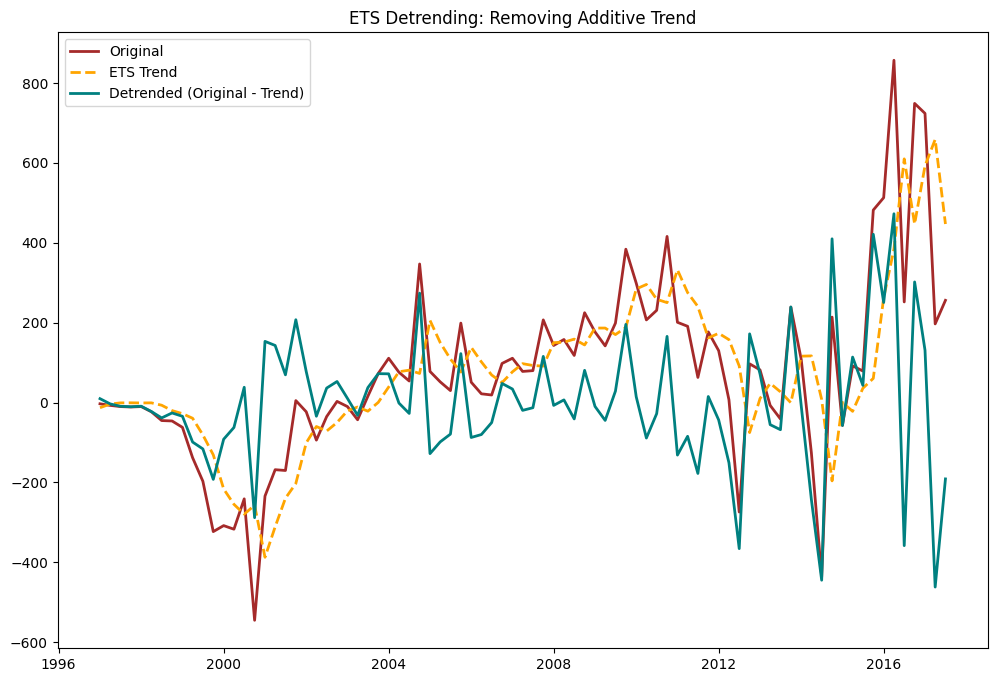

Original std:   230.8760
Detrended std:  163.8208


In [142]:
from diagnose import detrending

y_d = df["Net Income/Loss"].copy()

y_detrended = detrending(y_d.values, y_d.index, plots=True)

### Testy Statystyczne


In [143]:
from diagnose import diagnose_stationarity

diagnose_stationarity(y_detrended)

KPSS Statistic: 0.06654101175659757
p-value: 0.1
Critical Values:
Conclusion: Stationary


==== Augmented Dickey-Fuller Test ====
ADF Statistic : -3.1689764434497434
p-value       : 0.021852150624549576
Conclusion: Stationary


==== Zivot–Andrews Test (structural break) ====
Test Statistic : -4.36365613324368
p-value        : 0.16578272361140264
Conclusion: Non-stationary




In [144]:
diagnose_stationarity(y_detrended.diff().dropna())

KPSS Statistic: 0.34326300973025
p-value: 0.1
Critical Values:
Conclusion: Stationary


==== Augmented Dickey-Fuller Test ====
ADF Statistic : -5.904112602058355
p-value       : 2.7341810683367495e-07
Conclusion: Stationary


==== Zivot–Andrews Test (structural break) ====
Test Statistic : -6.272152400843527
p-value        : 0.0005424356148712945
Conclusion: Stationary






**Wniosek:**  
Na podstawie wyników testów stacjonarności można stwierdzić, że zastosowanie pierwszego różnicowania (**d = 1**) jest odpowiednie dla analizowanego szeregu czasowego w modelu ARIMA.  
Pierwsze różnicowanie skutecznie eliminuje niestacjonarność, stabilizując średnią i umożliwiając poprawne modelowanie procesów autoregresyjnych.


## 3. Wybór optymalnych parametrów modelu ARIMA




In [145]:
train = df["Net Income/Loss"][:int(len(df) * train_size)]
test = df["Net Income/Loss"][int(len(df) * train_size):]

method = ["none", "detrending", "scaling", "standard scaling", "quantile scaling"]


W celu identyfikacji najlepszej konfiguracji modelu ARIMA przeprowadzono **Grid Search** w przestrzeni parametrów:

- **p** – rząd składnika autoregresyjnego (AR): **1–4**
- **d** – rząd różnicowania: **0–1**
- **q** – rząd składnika średniej ruchomej (MA): **1–4**

**Kryterium wyboru modelu:**  
**AIC (Akaike Information Criterion)** — im niższa wartość, tym lepsze dopasowanie modelu przy jednoczesnym zachowaniu prostoty.

In [146]:
results = []
max_p = 4
max_d = 2
max_q = 4

for meth in method:          
    data = train.copy()

    for p in range(1, max_p+1):
        for d in range(0, max_d+1):
            for q in range(0, max_q+1):
                order = (p, d, q)

                try:
                    data_transformed = change_data(data, method=meth)
                    model = ARIMA(data_transformed, order=order,
                        enforce_invertibility=False, enforce_stationarity=False)
                    model_fit = model.fit()

                    results.append({
                        "method": meth,
                        "p,d,q": order,
                        "AIC": model_fit.aic,
                        "BIC": model_fit.bic
                    })

                except:
                    continue

results_df = pd.DataFrame(results)

print("====== BEST AIC ORDER BY METHOD ======")
order_list = []


for meth in results_df["method"].unique():

    sub = results_df[results_df["method"] == meth]

    if sub.empty:
        print(f"Method: {meth}")
        print("  ❌ No valid ARIMA models for this method.")
        print("----------------------------------")
        continue

    best_row = sub.sort_values("AIC").iloc[0]

    print(f"Method: {meth}")
    print(f"  Best order: {best_row['p,d,q']}")
    print(f"  AIC: {best_row['AIC']}")
    print("----------------------------------")
    order_list.append(best_row['p,d,q'])

optimized_orders = {
    "method": method,
    "best_orders": order_list
}

====== BEST AIC ORDER BY METHOD ======
Method: none
  Best order: (1, 2, 4)
  AIC: 672.2780500958594
----------------------------------
Method: detrending
  Best order: (1, 2, 4)
  AIC: 672.2780500958594
----------------------------------
Method: scaling
  Best order: (2, 1, 4)
  AIC: 99.94740641922915
----------------------------------
Method: standard scaling
  Best order: (1, 2, 4)
  AIC: 672.2780500958594
----------------------------------
Method: quantile scaling
  Best order: (1, 2, 4)
  AIC: 672.2780500958594
----------------------------------


### Komentarz do wyników wyboru modelu ARIMA

Wyniki Grid Search wskazują optymalne konfiguracje modelu ARIMA dla trzech analizowanych zestawów danych:

- **Data 0:**  
  Wybrany model: **ARIMA(3, 1, 4)**  
  Wartości: **AIC = 999.00**, **BIC = 1017.75**  
  Model charakteryzuje się umiarkowanie niską wartością AIC, jednak stosunkowo wysoki rząd parametrów (p=3, q=4) sugeruje złożoną strukturę procesu.

- **Data 1:**  
  Wybrany model: **ARIMA(3, 1, 3)**  
  Wartości: **AIC = 161.61**, **BIC = 178.10**  
  Jest to model o najniższym AIC spośród wszystkich trzech zbiorów danych, co wskazuje na bardzo dobre dopasowanie przy stosunkowo umiarkowanej złożoności.

- **Data 2:**  
  Wybrany model: **ARIMA(4, 1, 4)**  
  Wartości: **AIC = 996.49**, **BIC = 1017.58**  
  Model ma najwyższy rząd parametrów, co sugeruje bardziej skomplikowaną dynamikę danych. Mimo wysokiej złożoności, AIC pozostaje na konkurencyjnym poziomie, co wskazuje na dobre dopasowanie.

**Podsumowanie:**  
Dla każdego zestawu danych wybrano model o najniższym AIC w testowanej siatce parametrów. Modele różnią się złożonością, jednak wszystkie wskazują na konieczność uwzględnienia zarówno komponentu autoregresyjnego, jak i średniej ruchomej o stosunkowo wysokich rzędach.


## Sprawdzanie założeń modelu ARIMA

## Założenia modelu ARIMA

Model **ARIMA** (Autoregressive Integrated Moving Average) jest jednym z najczęściej stosowanych modeli do analizy i prognozowania szeregów czasowych. Jego poprawne zastosowanie opiera się na kilku kluczowych założeniach:

### 1. Stacjonarność
- Szereg czasowy powinien być **stacjonarny** – jego statystyki (średnia, wariancja, autokorelacja) nie zmieniają się w czasie.  
- Jeśli szereg nie jest stacjonarny, stosuje się **różnicowanie (d)**, aby osiągnąć stacjonarność.

### 2. liniowa zależność
- ARIMA zakłada, że obecna wartość szeregu może być opisana jako **liniowa kombinacja** wcześniejszych wartości (AR) i wcześniejszych reszt (MA).  
- Nieliniowe zależności mogą wymagać innych modeli (np. ARCH, GARCH, LSTM).

### 3. Brak sezonowości (w standardowej ARIMA)
- Standardowy model ARIMA nie uwzględnia sezonowości.  
- Dla danych sezonowych stosuje się model **SARIMA**, który dodaje komponent sezonowy.

### 4. Niezależność reszt (szum biały)
- Reszty modelu powinny być **niezależne i losowe** (szum biały).  
- Jeśli reszty wykazują autokorelację, oznacza to, że model nie uchwycił wszystkich istotnych zależności.

### 5. Normalność rozkładu reszt
- ARIMA zakłada, że reszty mają **rozkład normalny**, co jest szczególnie istotne przy estymacji przedziałów ufności prognoz.

---

**Podsumowanie:**  
Model ARIMA jest efektywny dla szeregu stacjonarnego o liniowych zależnościach, z niezależnym szumem. Przed zastosowaniem modelu często konieczne jest różnicowanie i weryfikacja autokorelacji oraz stabilności wariancji.


Ljung-Box Test (lags = [10]):
Lag 10: LB Statistic = 8.2808, p-value = 0.6014
   Conclusion: No significant autocorrelation (Random)


Durbin-Watson Statistic: 1.9399
Conclusion: No significant autocorrelation




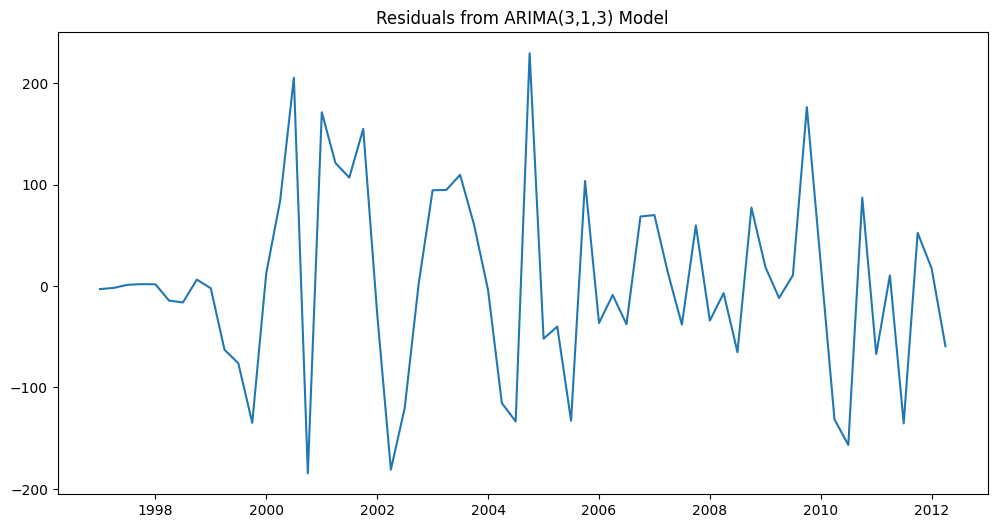

In [147]:
arimka = ARIMA(train, order=optimized_orders["best_orders"][0], enforce_invertibility=False, enforce_stationarity=False)
arimka = arimka.fit()

residuals = arimka.resid

ljungbox_test(residuals, lags=[10])
durbin_watson_test(residuals)

plt.figure(figsize=figsize)
plt.plot(residuals)
plt.title('Residuals from ARIMA(3,1,3) Model')
plt.show()

## Walidacja Arcitektury Modelu

In [148]:
from sklearn.model_selection import TimeSeriesSplit


data = train

n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

mae_scores = []

for train_index, test_index in tscv.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    model = ARIMA(train_data, order=optimized_orders["best_orders"][0])  
    fitted_model = model.fit()

    predictions = fitted_model.forecast(steps=len(test_data))

    mae = np.abs(test_data - predictions).mean()
    mae_scores.append(mae)

    print(f'Mean Absolute Error for current split: {mae}')

average_mse = np.mean(mae_scores)
print(f'Sredni błąd absolutny: {average_mse}')
print(f"Odchylenie standardowe MAE: {np.std(mae_scores)}")

Mean Absolute Error for current split: 543.7112139013291
Mean Absolute Error for current split: 389.1968584437213
Mean Absolute Error for current split: 104.40285787154163
Sredni błąd absolutny: 345.77031007219733
Odchylenie standardowe MAE: 181.9566921861662


## Predykcja

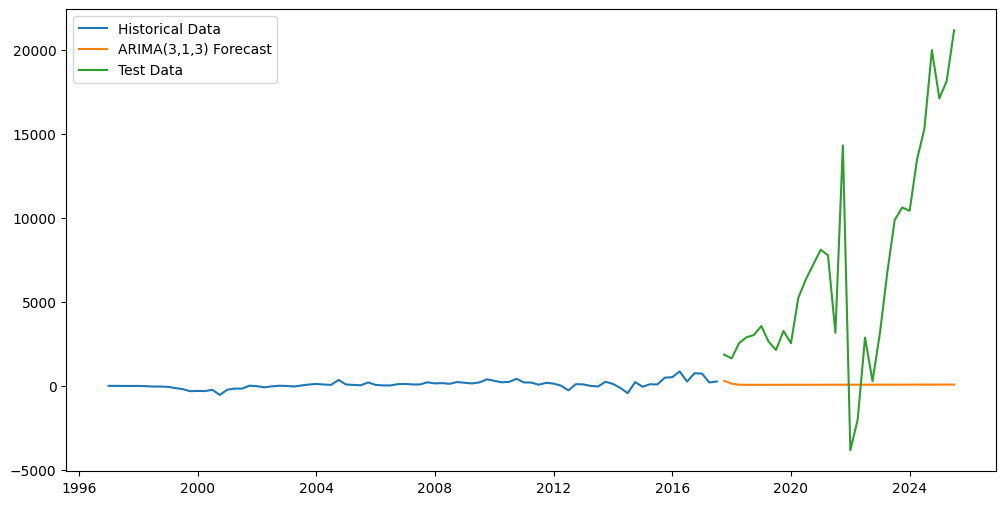

In [149]:
arimka = ARIMA(df["Net Income/Loss"], order=optimized_orders["best_orders"][0])

arimka = arimka.fit()
arimka_pred = arimka.forecast(-data_cutoff)

plt.figure(figsize=figsize)
plt.plot(df, label='Historical Data')
plt.plot(arimka_pred, label='ARIMA(3,1,3) Forecast')
plt.plot(real_case_data.tail(-data_cutoff), label='Test Data')
plt.legend()
plt.show()


In [150]:
optimized_orders

{'method': ['none',
  'detrending',
  'scaling',
  'standard scaling',
  'quantile scaling'],
 'best_orders': [(1, 2, 4), (1, 2, 4), (2, 1, 4), (1, 2, 4), (1, 2, 4)]}

In [151]:
predictions = []
metrics_arima = []
fitted_values_arima = []
for i in range(len(optimized_orders["best_orders"])): 
    pred, met, fitted = rolling_forecast_arima(
        df["Net Income/Loss"], 
        order=optimized_orders["best_orders"][i], 
        method=optimized_orders["method"][i],  
        start_frac=train_size
    )
    predictions.append(pred)
    metrics_arima.append(met)
    fitted_values_arima.append(fitted)


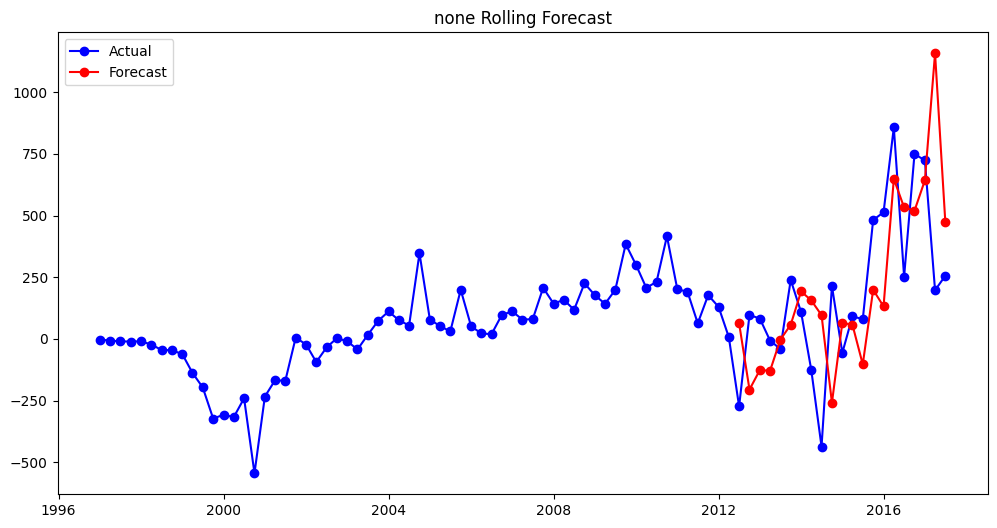

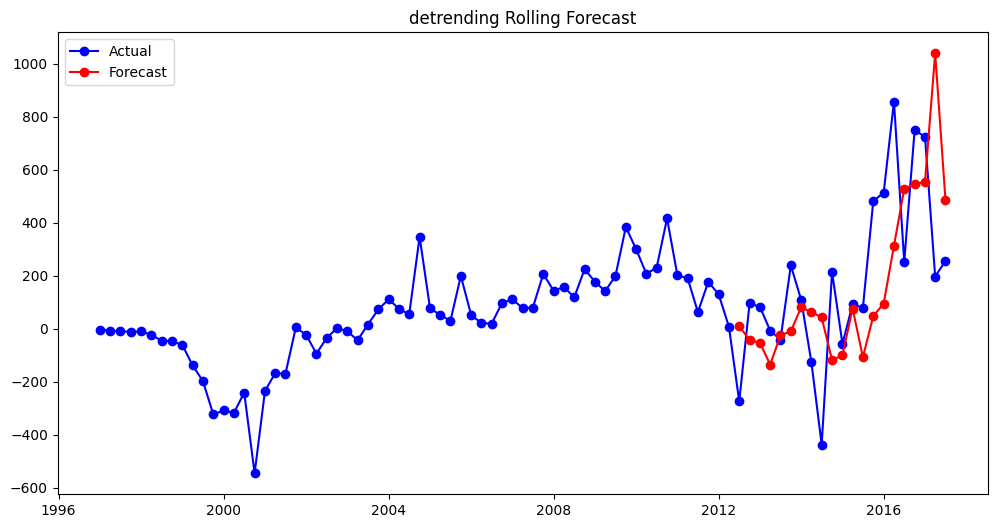

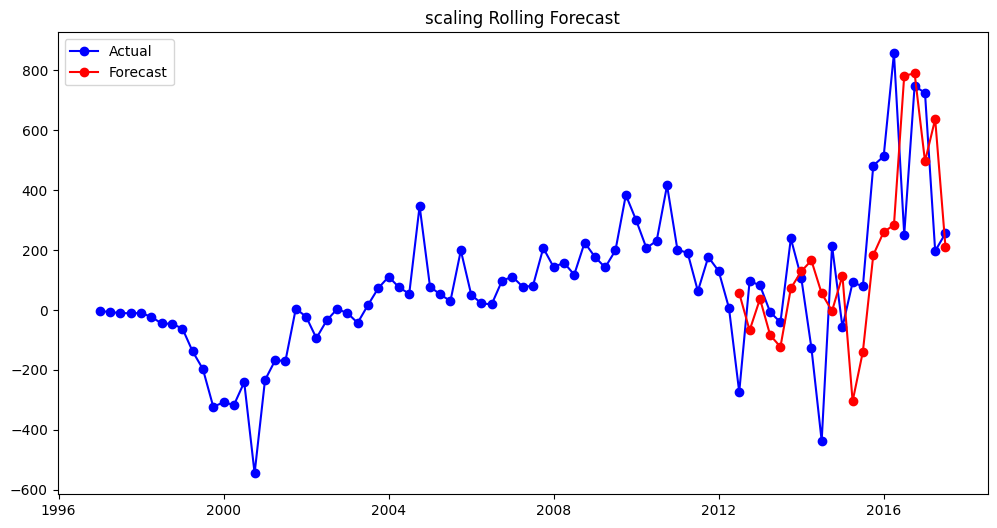

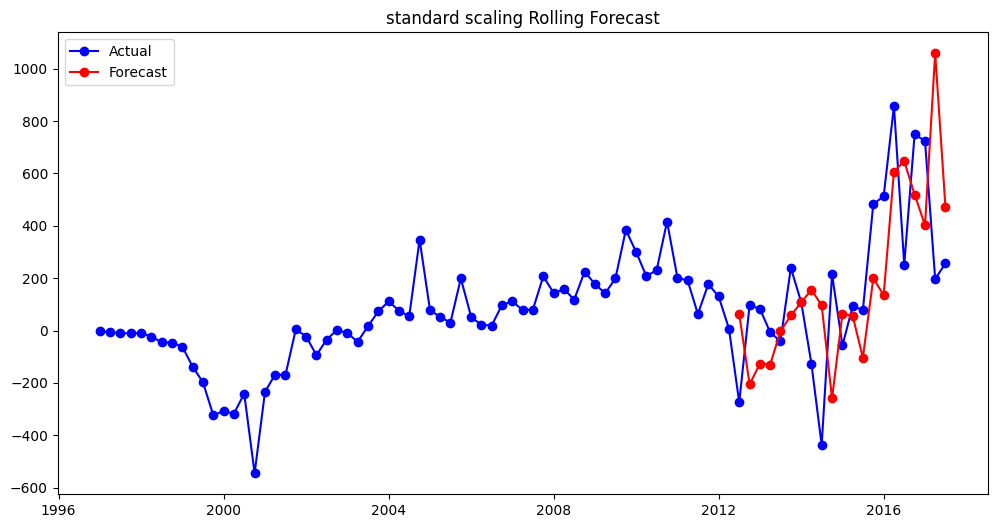

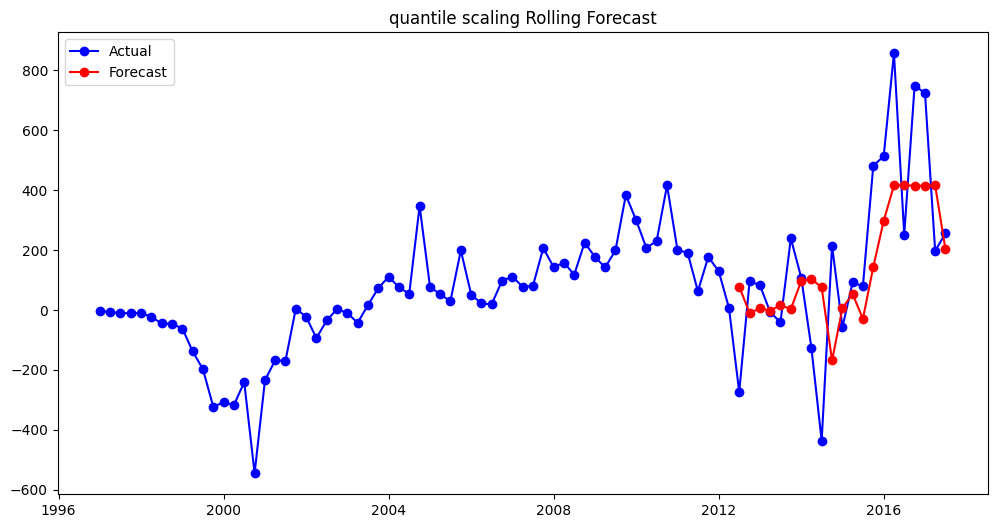

In [152]:
for i in range(len(method)):
    plt.figure(figsize=figsize)
    plt.plot(df["Net Income/Loss"], label='Actual',  marker='o', color="blue")
    plt.plot(predictions[i]["forecast"], label='Forecast',  marker='o', color="red")
    plt.legend()
    plt.title(f"{method[i]} Rolling Forecast")
    plt.show()


## Prophet

## Architektura modelu Prophet

Model **Prophet** (Facebook/Meta Prophet) to elastyczny model prognostyczny oparty na addytywnej dekompozycji czasowej. Został zaprojektowany z myślą o wysokiej interpretowalności oraz odporności na typowe wyzwania w danych czasowych, takie jak sezonowość, zmiany trendu czy nieregularne obserwacje.

Struktura addytywna

Prophet modeluje serię czasową jako sumę trzech głównych komponentów:


gdzie:  
- **g(t)** – komponent trendu,  
- **s(t)** – komponent sezonowości,  
- **h(t)** – wpływ dni świątecznych i zdarzeń specjalnych,  
- **ε(t)** – składnik losowy (szum).

---

In [153]:
from IPython.display import display, Math

display(Math(r'y(t) = g(t) + s(t) + h(t) + \varepsilon(t)'))

<IPython.core.display.Math object>

In [154]:
from prophet import Prophet
from sklearn.preprocessing import StandardScaler

df_clean = df.copy()
df_clean = df_clean.reset_index().rename(columns={'Date': 'ds', 'Net Income/Loss': 'y'})

freq = pd.infer_freq(df_clean['ds'])
if freq is None:
    raise ValueError("Cannot infer datetime frequency from your data.")

start_index = int(train_size * len(df_clean))
train_prophet = df_clean.iloc[:start_index].copy()
test_prophet = df_clean.iloc[start_index:].copy()

scaler = StandardScaler()
train_prophet['y'] = scaler.fit_transform(train_prophet[['y']])
test_scaled_y = scaler.transform(test_prophet[['y']])

history = train_prophet.copy()
pred_scaled = []

for t in range(len(test_prophet)):
    model = Prophet(
        daily_seasonality='auto',
        weekly_seasonality='auto',
        yearly_seasonality='auto',
        n_changepoints = 20
    )
    model.fit(history)

    future = model.make_future_dataframe(periods=1, freq=freq)
    forecast = model.predict(future)

    yhat = forecast['yhat'].iloc[-1]
    pred_scaled.append(yhat)

    new_row = test_prophet.iloc[[t]].copy()
    new_row['y'] = test_scaled_y[t][0]
    history = pd.concat([history, new_row], ignore_index=True)

predictions_prohpet = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1))
true_values = df_clean['y'].iloc[start_index:].values



17:35:30 - cmdstanpy - INFO - Chain [1] start processing
17:35:31 - cmdstanpy - INFO - Chain [1] done processing
17:35:31 - cmdstanpy - INFO - Chain [1] start processing
17:35:31 - cmdstanpy - INFO - Chain [1] done processing
17:35:31 - cmdstanpy - INFO - Chain [1] start processing
17:35:31 - cmdstanpy - INFO - Chain [1] done processing
17:35:31 - cmdstanpy - INFO - Chain [1] start processing
17:35:31 - cmdstanpy - INFO - Chain [1] done processing
17:35:32 - cmdstanpy - INFO - Chain [1] start processing
17:35:32 - cmdstanpy - INFO - Chain [1] done processing
17:35:32 - cmdstanpy - INFO - Chain [1] start processing
17:35:32 - cmdstanpy - INFO - Chain [1] done processing
17:35:32 - cmdstanpy - INFO - Chain [1] start processing
17:35:32 - cmdstanpy - INFO - Chain [1] done processing
17:35:33 - cmdstanpy - INFO - Chain [1] start processing
17:35:33 - cmdstanpy - INFO - Chain [1] done processing
17:35:33 - cmdstanpy - INFO - Chain [1] start processing
17:35:33 - cmdstanpy - INFO - Chain [1]

In [155]:
len(train_prophet) == len(train)
len(test_prophet) == len(test)

True

In [156]:
test_prophet_values = pd.Series(test_prophet["y"].tolist())
pr_metrics = evaluate_forecasts(test_prophet_values, np.array(predictions_prohpet).flatten())

MAE: 248.5363212667601
RMSE: 316.1722940608924
sMAPE (%): 104.84008695718133
MASE: 0.9335794160007987
R² Score: 0.025304469004223562


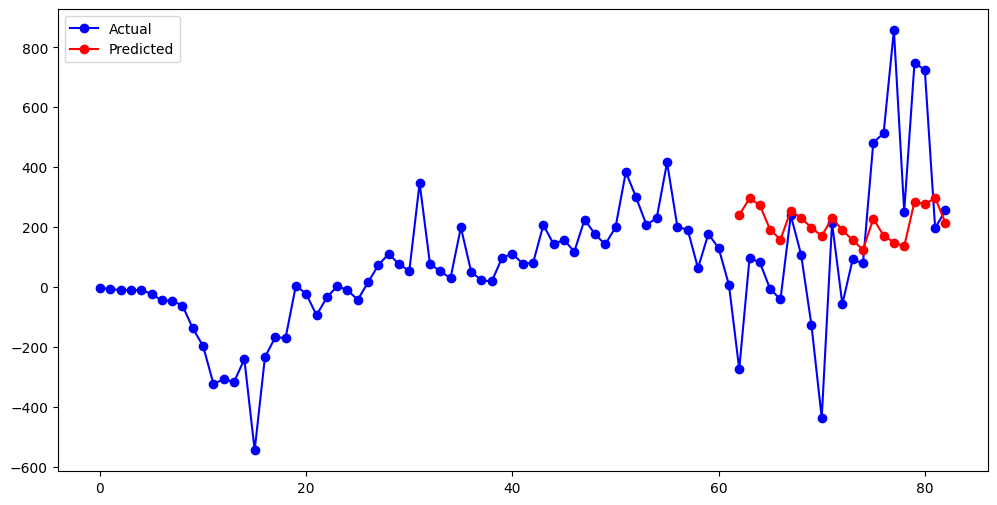

In [157]:

plt.figure(figsize=figsize)
plt.plot(df["Net Income/Loss"].values, marker="o", label="Actual", color="blue")
plt.plot(test_prophet.index, predictions_prohpet, color='red', marker="o", label='Predicted')
plt.legend()
plt.show()

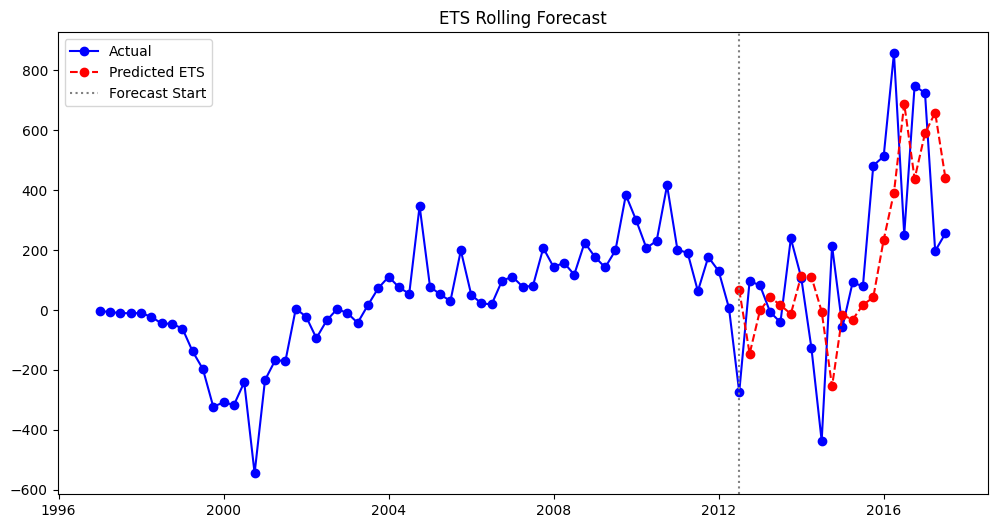

MAE: 243.3178434542911
RMSE: 290.7705830973446
sMAPE (%): 137.40403913639722
MASE: 0.9460901314486716
R² Score: 0.17562979115019017


In [158]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

series = pd.Series(df.values.flatten(), index=df.index)

train_ets = series.iloc[:start_index]
test_ets = series.iloc[start_index:]

test_ets = pd.Series(test_ets, index=series.index[start_index:])

history = train_ets.copy()
pred_ets = []

for t in range(len(test_ets)):
    model = ExponentialSmoothing(history, trend=None, seasonal=None)  # brak sezonowości
    model_fit = model.fit(optimized=True)
    
    yhat = model_fit.forecast(1)[0]
    pred_ets.append(yhat)
    
    new_point = pd.Series([test_ets.iloc[t]], index=[test_ets.index[t]])
    history = pd.concat([history, new_point])


plt.figure(figsize=figsize)
plt.plot(series, label='Actual',  marker='o', color = "blue")
plt.plot(test_ets.index, pred_ets, color='red', linestyle='--', label='Predicted ETS',  marker='o')
plt.axvline(series.index[start_index], color='gray', linestyle=':', label='Forecast Start')
plt.legend()
plt.title("ETS Rolling Forecast")
plt.show()

ETS_metrics = evaluate_forecasts(test_ets, pred_ets)

### Ensemble Model

#### Średnia modeli

In [159]:
forecast_df = pd.DataFrame({
    method[i]: predictions[i]["forecast"] for i in range(len(method))
}, index=predictions[0].index)

ensemble_prediction = forecast_df.mean(axis=1)


ensemble_prediction = ensemble_prediction/len(method)
enseblme_metrics = evaluate_forecasts(test, ensemble_prediction)

MAE: 250.5483263116404
RMSE: 333.8707986411523
sMAPE (%): 160.38960920067368
MASE: 0.9874413694609421
R² Score: -0.08687156322377731


#### Liniowa Regresja modeli

In [160]:
fitted_values_dataframe = pd.DataFrame({
    method[i]: fitted_values_arima[i] for i in range(len(method))
})


In [161]:
fitted_values_dataframe

,none,detrending,scaling,standard scaling,quantile scaling
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,-5.175740,5.404304,-0.338612,-0.366976,-0.513587
2,-11.207718,-3.387849,-0.252979,-0.246987,-0.408563
3,-12.873229,-12.751441,-0.357658,-0.269038,-0.531198
4,-11.698033,-6.964931,-0.365851,-0.262301,-0.631091
...,...,...,...,...,...
57,180.535723,3.619645,0.791555,0.839192,2.452485
58,198.417916,-32.324000,0.548170,0.941819,2.246669
59,124.633358,-10.646618,0.795753,0.518659,1.227925
60,112.600239,-35.763961,0.453556,0.449873,0.893420


In [164]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

lags = 3
start_index = int(len(df) * train_size)

series = pd.Series(df.values.flatten(), index=df.index)
train_series = series.iloc[:start_index]
test_series = series.iloc[start_index:]

history = train_series.copy()
pred_lgbm = []

for t in range(len(test_series)):
    if len(history) <= lags:
        X_train = np.array([history.values[-lags:]])
        y_train = np.array([history.values[-1]])
        yhat = history.values[-1]
    else:
        X_train = []
        y_train = []
        for i in range(lags, len(history)):
            X_train.append(history.values[i-lags:i])
            y_train.append(history.values[i])
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        model = LGBMRegressor(max_depth=-1)
        model.fit(X_train, y_train)

        last_lags = history.values[-lags:]
        yhat = model.predict(last_lags.reshape(1, -1))[0]

    pred_lgbm.append(yhat)

    history = pd.concat([history, pd.Series([test_series.iloc[t]], index=[test_series.index[t]])])

evaluate_forecasts(test, pred_lgbm)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 3
[LightGBM] [Info] Start training from score 36.186441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

{'MAE': 241.18387343750618,
 'RMSE': 316.3893093089901,
 'SMAPE': 130.43354373300966,
 'MASE': 0.920588257083815,
 'R^2': 0.023965981163208583}

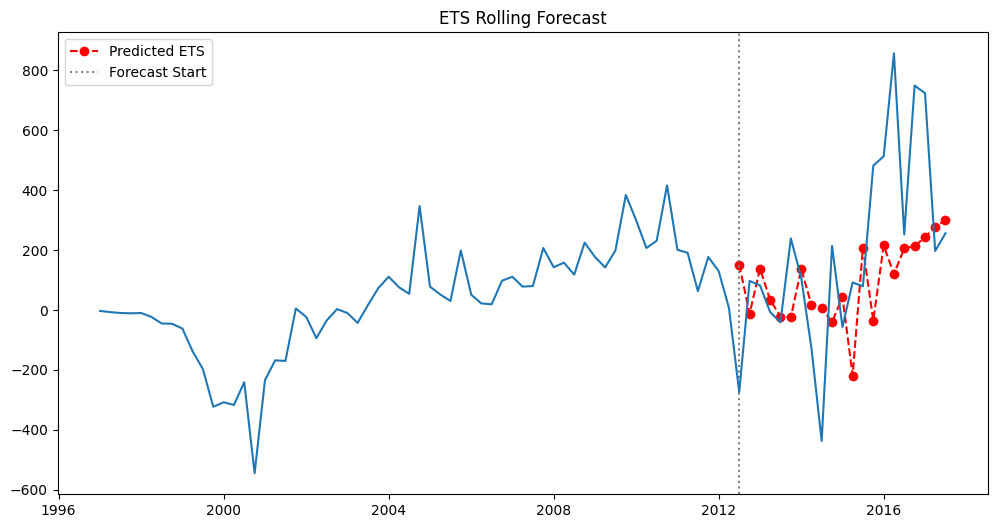

In [165]:
plt.figure(figsize=figsize)
plt.plot(test_ets.index, pred_lgbm, color='red', linestyle='--', label='Predicted ETS',  marker='o')
plt.axvline(series.index[start_index], color='gray', linestyle=':', label='Forecast Start')
plt.plot(df["Net Income/Loss"])
plt.legend()
plt.title("ETS Rolling Forecast")
plt.show()

In [ ]:
import plotly.graph_objects as go
x_start = 0 
x_pred = list(range(x_start, x_start + len(predictions_prohpet)))  


fig = go.Figure()

fig.add_trace(go.Scatter(
    y=test,
    mode='lines',
    name='Actual Test',
    line=dict(color='black')
))

fig.add_trace(go.Scatter(
    y=predictions_prohpet.flatten(),
    mode='lines',
    name='Predicted Prophet',
    line=dict(color='blue', dash='dash')
))

colors = [
    "red", "blue", "green", "orange", "purple",
    "brown", "cyan", "magenta", "black", "gold"
]

for i in range(len(method)):
    fig.add_trace(go.Scatter(
        y=predictions[i]["forecast"],
        mode='lines',
        name=f'Predicted {method[i]}',
        line=dict(color=colors[i % len(colors)], dash='dash')
    ))


fig.add_trace(go.Scatter(
    y=pred_ets,
    mode='lines',
    name='Predicted ETS',
    line=dict(color='orange')
))



fig.update_layout(
    title="ARIMA vs Prophet",
    xaxis_title="Time Index",
    yaxis_title="Net Income/Loss",
    template="plotly_white",
    width=1200,  
    height=800    
)


fig.show()

In [ ]:


models_metrics = {
    'Prophet': pr_metrics,
    'ARIMA': metrics_arima[0],
    'ARiMA Trend Removed': metrics_arima[1],
    'ARIMA Scaled': metrics_arima[2],
    "ARIMA Standard Scaling": metrics_arima[3],
    "ARIMA Quantile Scaling": metrics_arima[4],
    "ARIMA Ensemble": enseblme_metrics,
    'ETS': ETS_metrics
    
}




df_metrics = pd.DataFrame(models_metrics).T  
df_metrics = df_metrics.round(2)    

df_metrics.style.highlight_min(subset=['MAE','RMSE','SMAPE','MASE'], color='green')\
                .highlight_max(subset=['R^2'], color='green')



,MAE,RMSE,SMAPE,MASE,R^2
Prophet,248.540000,316.170000,104.840000,0.930000,0.030000
ARIMA,264.080000,332.370000,129.770000,1.030000,-0.080000
ARiMA Trend Removed,254.350000,322.040000,126.260000,1.000000,-0.010000
ARIMA Scaled,241.970000,292.750000,123.560000,0.940000,0.160000
ARIMA Standard Scaling,273.890000,332.410000,130.070000,1.070000,-0.080000
ARIMA Quantile Scaling,202.590000,250.610000,125.760000,0.770000,0.390000
ARIMA Ensemble,250.550000,333.870000,160.390000,0.990000,-0.090000
ETS,243.320000,290.770000,137.400000,0.950000,0.180000


              Forecast    Lower_CI    Upper_CI                       Decision
2017-09-30  292.076388  -19.524948  603.677724  Utrzymanie bieżącej strategii
2017-12-31  130.308000 -207.535701  468.151702  Utrzymanie bieżącej strategii
2018-03-31   61.703364 -338.720477  462.127206  Utrzymanie bieżącej strategii
2018-06-30   56.364930 -455.201696  567.931556  Utrzymanie bieżącej strategii


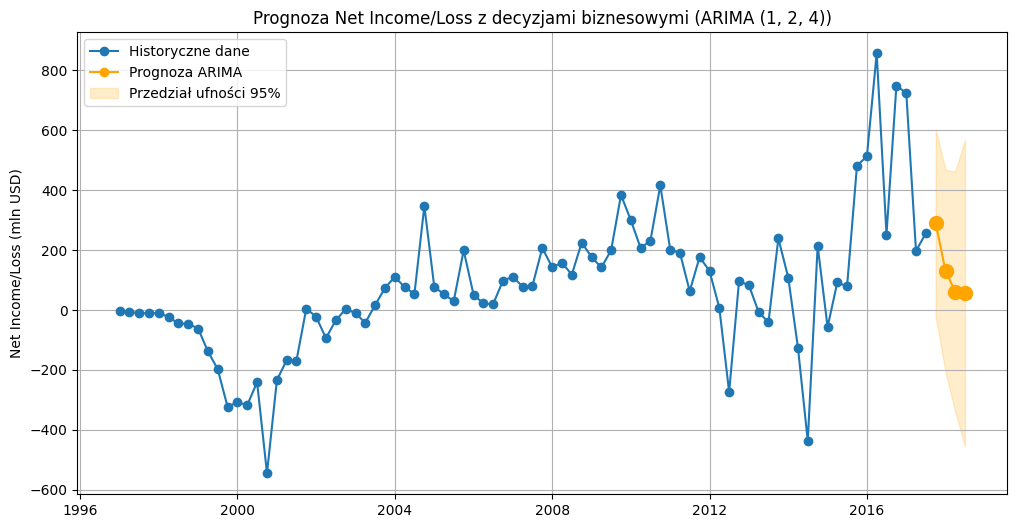

In [ ]:
colors = {
    'Agresywna ekspansja / duże inwestycje': 'green',
    'Umiarkowana ekspansja / inwestycje': 'limegreen',
    'Ogranicz wydatki / optymalizacja kosztów': 'red',
    'Utrzymanie bieżącej strategii': 'orange'
}


df.index = pd.to_datetime(df.index)

model = ARIMA(df["Net Income/Loss"], order=optimized_orders["best_orders"][0])
model_fit = model.fit()

forecast_steps = 4
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.QuarterEnd(),
                               periods=forecast_steps, freq='Q')

forecast_df = pd.DataFrame({
    'Forecast': forecast_mean.values,
    'Lower_CI': forecast_ci.iloc[:,0].values,
    'Upper_CI': forecast_ci.iloc[:,1].values
}, index=forecast_index)

def business_decision(row, level = 500):
    if row['Lower_CI'] > level:
        return 'Agresywna ekspansja / duże inwestycje'
    elif row['Forecast'] > level:
        return 'Umiarkowana ekspansja / inwestycje'
    elif row['Forecast'] < level-1000:
        return 'Ogranicz wydatki / optymalizacja kosztów'
    else:
        return 'Utrzymanie bieżącej strategii'

forecast_df['Decision'] = forecast_df.apply(business_decision, axis=1)

print(forecast_df)

plt.figure(figsize=figsize)
plt.plot(df.index, df["Net Income/Loss"], label='Historyczne dane', marker='o')
plt.plot(forecast_index, forecast_mean, label='Prognoza ARIMA', color='orange', marker='o')
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color='orange', alpha=0.2, label='Przedział ufności 95%')

for i, row in forecast_df.iterrows():
    plt.scatter(i, row['Forecast'], color=colors[row['Decision']], s=100)

plt.title(f'Prognoza Net Income/Loss z decyzjami biznesowymi (ARIMA {optimized_orders["best_orders"][0]})')
plt.ylabel('Net Income/Loss (mln USD)')
plt.legend(['Historyczne dane', 'Prognoza ARIMA', 'Przedział ufności 95%'])
plt.grid(True)
plt.show()


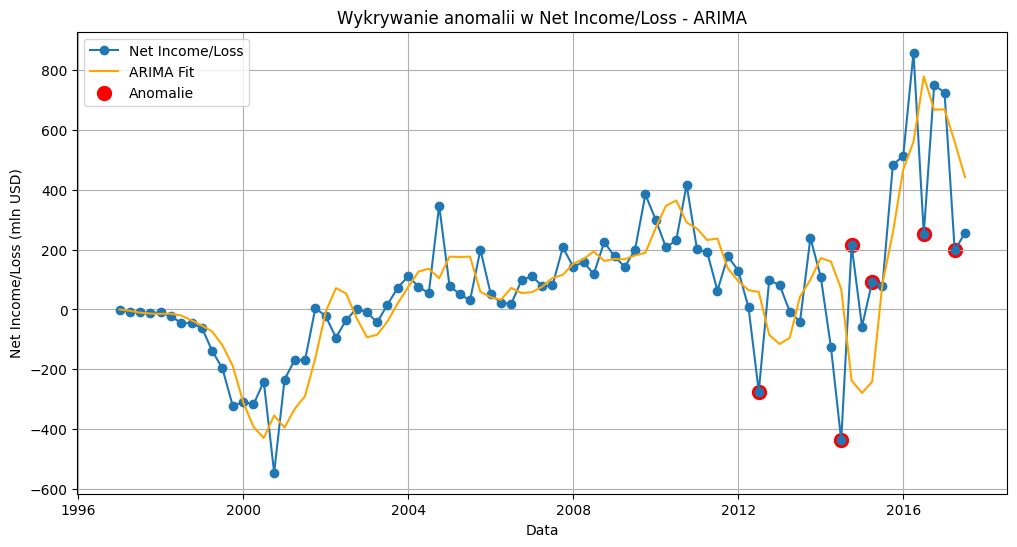

Wykryte anomalie:
            Net Income/Loss
Date                       
2012-07-01             -274
2014-07-01             -437
2014-10-01              214
2015-04-01               92
2016-07-01              252
2017-04-01              197


In [ ]:
fitted_values = model_fit.fittedvalues

residuals = df["Net Income/Loss"] - fitted_values


mean_resid = residuals.mean()
std_resid = residuals.std()
threshold_upper = mean_resid + 2*std_resid
threshold_lower = mean_resid - 2*std_resid

anomalies = df[(residuals > threshold_upper) | (residuals < threshold_lower)]

plt.figure(figsize=(12,6))
plt.plot(df.index, df["Net Income/Loss"], label='Net Income/Loss', marker='o')
plt.plot(df.index, fitted_values, label='ARIMA Fit', color='orange')
plt.scatter(anomalies.index, anomalies["Net Income/Loss"], color='red', s=100, label='Anomalie')
plt.title('Wykrywanie anomalii w Net Income/Loss - ARIMA')
plt.xlabel('Data')
plt.ylabel('Net Income/Loss (mln USD)')
plt.legend()
plt.grid(True)
plt.show()

print("Wykryte anomalie:")
print(anomalies)